In [1]:
import torch as th
import torch.nn.functional as th_f
import torchaudio as th_audio
import torchaudio.functional as th_audio_f

import torch_scatter

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
wav_path = "/home/samuel/Téléchargements/06 D'yer Mak'er.wav"

In [3]:
raw_audio, _ = th_audio.load(wav_path)

In [4]:
raw_audio_mono = raw_audio.mean(0)[:44100 * 30]

In [5]:
nperseg = 2 ** 10

stride = 2 ** 8

In [6]:
print(nperseg)
print(stride)

1024
256


In [7]:
hann_window = th.hann_window(nperseg)

complex_values = th_audio_f.spectrogram(
    raw_audio_mono,
    pad=0, window=hann_window,
    n_fft=nperseg, hop_length=stride, win_length=nperseg,
    power=None, normalized=True,
    return_complex=True
)

In [8]:
complex_values.size()

torch.Size([513, 5168])

In [9]:
complex_without_nyquist = complex_values[:-1, :]

In [10]:
n_bins = complex_without_nyquist.size()[0]

required_length = 512

# Mel

In [52]:
min_hz = 20.
max_hz = 44100 // 2

In [53]:
def hz2mel(hz):
    return 2595. * th.log(th.tensor(1.) + hz / 700.) / th.log(th.tensor(10.))

def mel2hz(erb):
    return (10. ** (erb / 2595.) - 1.) * 700.

In [54]:
min_mel = hz2mel(th.tensor(min_hz))
max_mel = hz2mel(th.tensor(max_hz))

In [55]:
min_mel, max_mel

(tensor(31.7485), tensor(3923.3374))

In [56]:
bucket_boundaries = mel2hz(th.linspace(min_mel, max_mel, required_length))

### Test : scale magn

In [57]:
scale = hz2bark(th.linspace(min_hz, max_hz, n_bins))[:, None]
scale = scale / scale.norm()

In [58]:
scale.size()

torch.Size([512, 1])

In [59]:
complex_without_nyquist.size()

torch.Size([512, 5168])

In [60]:
magn = th.abs(complex_without_nyquist)
phase = th.angle(complex_without_nyquist)

In [61]:
phase = unwrap(phase)
phase = phase[:, 1:] - phase[:, :-1]

magn = magn[:, 1:]

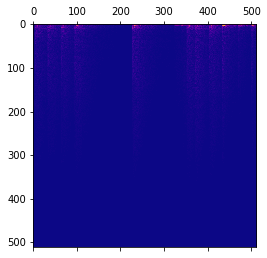

In [62]:
bl = magn[:, 60:60+512].numpy()

bl = bl / (bl.max() - bl.min())

plt.matshow(bl, cmap="plasma")
plt.show()

In [63]:
scaled_magn = magn * scale

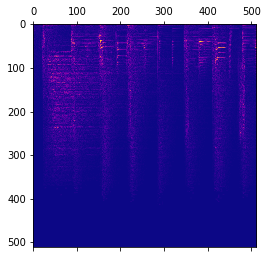

In [64]:
bl = scaled_magn[:, 600:600+512].numpy()

bl = bl / (bl.max() - bl.min())

plt.matshow(bl, cmap="plasma")
plt.show()

# ERB

In [21]:
min_hz = 0.
max_hz = 44100 // 2

In [22]:
def hz2erb(hz):
    return 21.4 * th.log(th.tensor(1.) + 0.00437 * hz) / th.log(th.tensor(10.))

def erb2hz(erb):
    return (10. ** (erb / 21.4) - 1.) / 0.00437

In [23]:
min_erb = hz2erb(th.tensor(min_hz))
max_erb = hz2erb(th.tensor(max_hz))

In [24]:
min_erb, max_erb

(tensor(0.), tensor(42.5512))

In [25]:
bucket_boundaries = erb2hz(th.linspace(min_erb, max_erb, required_length))

# Bark

In [31]:
def hz2bark(f):
    b = 6 * th.arcsinh(f / 600)
    return b
    
    
def bark2hz(b):
    f = 600 * th.sinh(b / 6)
    return f

In [13]:
min_hz = 0.
max_hz = 44100 // 2

In [14]:
min_bark = hz2bark(th.tensor(min_hz))
max_bark = hz2bark(th.tensor(max_hz))

In [15]:
min_bark, max_bark

(tensor(0.), tensor(25.7848))

In [16]:
bucket_boundaries = bark2hz(th.linspace(min_bark, max_bark, required_length))

In [17]:
bucket_boundaries.size()

torch.Size([512])

# Scatter

In [18]:
frequencies = th.linspace(min_hz, max_hz, n_bins)

In [19]:
buckets = th.bucketize(frequencies, bucket_boundaries)

In [20]:
#buckets_count = th.bincount(buckets) + 1

In [21]:
complex_without_nyquist.size()

torch.Size([2048, 5168])

In [22]:
buckets.unique().size()

torch.Size([451])

In [23]:
#res = res.scatter_add_(0, buckets[:, None].repeat(1, complex_without_nyquist.size()[1]), complex_without_nyquist)

buckets_tmp = buckets[:, None].repeat(1, complex_without_nyquist.size()[1])

real = th.real(complex_without_nyquist)
imag = th.imag(complex_without_nyquist)

real_res = torch_scatter.scatter_mean(real, buckets_tmp, dim=0)
imag_res = torch_scatter.scatter_mean(imag, buckets_tmp, dim=0)

complex_res = real_res + 1j * imag_res

In [24]:
complex_res.size()

torch.Size([512, 5168])

# Magn Phase

In [57]:
magn = th.abs(complex_res)
phase = th.angle(complex_res)

In [25]:
def diff(x: th.Tensor) -> th.Tensor:
    """

    :param x:
    :type x:
    :return:
    :rtype:
    """
    return th_f.pad(x[:, 1:] - x[:, :-1], (1, 0, 0, 0), "constant", 0)


def unwrap(phi: th.Tensor) -> th.Tensor:
    """

    :param phi:
    :type phi:
    :return:
    :rtype:
    """
    dphi = diff(phi)
    dphi_m = ((dphi + np.pi) % (2 * np.pi)) - np.pi
    dphi_m[(dphi_m == -np.pi) & (dphi > 0)] = np.pi
    phi_adj = dphi_m - dphi
    phi_adj[dphi.abs() < np.pi] = 0
    return phi + phi_adj.cumsum(1)

In [59]:
phase = unwrap(phase)
phase = phase[:, 1:] - phase[:, :-1]

magn = magn[:, 1:]

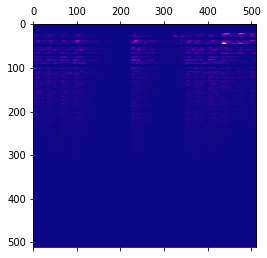

In [60]:
bl = magn[:, 60:60+512].numpy()

bl = bl / (bl.max() - bl.min())

plt.matshow(bl, cmap="plasma")
plt.show()

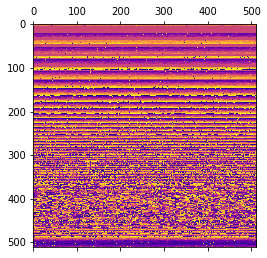

In [61]:
bl = phase[:, 60:60+512].numpy()

bl = bl / (bl.max() - bl.min())

plt.matshow(bl, cmap="plasma")
plt.show()

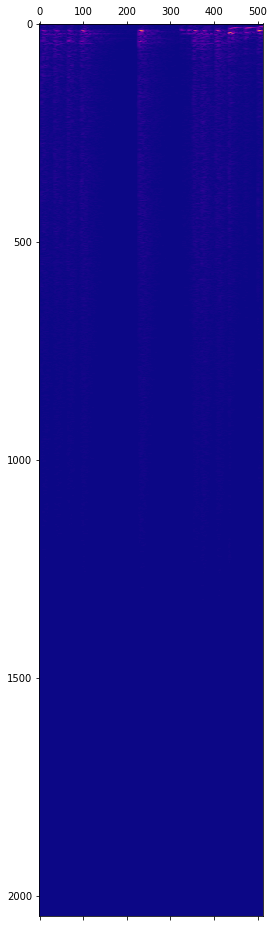

In [62]:
plt.matshow(th.abs(complex_without_nyquist[:, 60:60+512]).numpy(), cmap="plasma")
plt.show()

# Inverse

In [63]:
magn.size(), phase.size()

(torch.Size([512, 5167]), torch.Size([512, 5167]))

In [64]:
for i in range(phase.size()[1] - 1):
    phase[:, i + 1] = phase[:, i + 1] + phase[:, i]

phase = phase % (2 * np.pi)

In [65]:
z = magn * th.cos(phase) + magn * th.sin(phase) * 1j

In [66]:
decompressed_z = th.zeros(n_bins, z.size()[1], dtype=th.complex64)

In [67]:
decompressed_z.size()

torch.Size([2048, 5167])

In [68]:
buckets.size()

torch.Size([2048])

In [69]:
buckets

tensor([  0,   3,   5,  ..., 511, 511, 511])

In [70]:
for i, b in enumerate(tqdm(buckets)):
    decompressed_z[i, :] = z[b, :]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:00<00:00, 75694.25it/s]


In [71]:
decompressed_z = th.cat([decompressed_z, th.zeros(1, decompressed_z.size()[1]) + 1j * th.zeros(1, decompressed_z.size()[1])], dim=0)

In [72]:
decompressed_z.size()

torch.Size([2049, 5167])

In [73]:
hann_window = th.hann_window(nperseg)

raw_audio = th_audio_f.inverse_spectrogram(
        decompressed_z, length=None,
        pad=0, window=hann_window,
        n_fft=nperseg, hop_length=stride,
        win_length=nperseg, normalized=True
)

In [74]:
th_audio.save("output.wav", raw_audio[None, :], 44100)

In [75]:
tmp = th.rand(10, 20, dtype=th.complex64)

In [76]:
tmp.mean()

tensor(0.5321+0.5349j)

In [77]:
th.real(tmp).mean()

tensor(0.5321)

In [78]:
th.imag(tmp).mean()

tensor(0.5349)